In [1]:
from src.logger import *
from src.exception import CustomException
import os
import pandas as pd
import sys
from neuralprophet import NeuralProphet, set_log_level
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from src.components.model_training import *
from src.components.data_ingestion import DataLoader
from src.components.data_transformation import DataTransformer
from src.utils import *
import mlflow
from src.mlflow_utils import *
from src.utils import *
import logging

# Set the logging level to ERROR to suppress INFO and WARNING messages
logging.getLogger('NeuralProphet').setLevel(logging.ERROR)

In [2]:
# ####################################################################################################
# # Data Loading
# ####################################################################################################
# data_directory = '../Data/train_data/'  # Update this with the path to your /Data directory
# data_loader = DataLoader(data_directory)
# df_full = data_loader.load_all_parquet_files()


# ####################################################################################################
# # Data Transformation
# ####################################################################################################
# split_date = '2023-12-31'
# transformer = DataTransformer(df_full)
# df_daily_sum = transformer.transform_data()
# train_data, test_data = transformer.split_data(df_daily_sum, split_date = split_date)
# plot_data(df_daily_sum)

# ####################################################################################################
# # Data Saving
# ####################################################################################################
# save_to_csv(train_data, "../artifacts/train_data.csv")
# save_to_csv(test_data, "../artifacts/test_data.csv")

In [2]:
train_data = read_csv_and_convert_date('../artifacts/train_data.csv')
test_data = read_csv_and_convert_date('../artifacts/test_data.csv')

# **Model Training**

In [30]:
# hyperparameters = {
#     'growth': ['linear'],
#     'learning_rate': [0.03],
#     'n_changepoints': [10],
#     'changepoints_range': [ 0.95],
#     'yearly_seasonality': [False],
#     'weekly_seasonality': [True],
#     'daily_seasonality': [False],
#     'epochs': [50],
#     'trend_reg': [0.5]
# }

hyperparameters = {
    'growth': ['linear'],
    'seasonality_mode': ['additive'],
    'learning_rate': [0.003],
    'n_changepoints': [0, 1],
    'changepoints_range': [0.95],
    'yearly_seasonality': [ "auto", True],
    'weekly_seasonality': ["auto",True],
    'daily_seasonality': ["auto",True],
    'epochs': [150],
    'trend_reg': [5]
}

# hyperparameters = {
#     'growth': ['linear'],
#     'seasonality_mode': ['additive', 'multiplicative'],
#     'learning_rate': [0.03, 0.003],
#     'n_changepoints': [10, 25, 30],
#     'changepoints_range': [0.8, 0.95],
#     'yearly_seasonality': [True, False],
#     'weekly_seasonality': [True, False],
#     'daily_seasonality': [False],
#     'epochs': [300],
#     'trend_reg': [0, 0.5, 5]
# }

In [ ]:
logging.info(r"HyperParameter Tuning started")

experiment_name = "Neural_Prohet"
artifact_location = experiment_name+"_artifacts"
seed = 42

experiment_id = create_mlflow_experiment(
    experiment_name=experiment_name, 
    artifact_location=artifact_location,
    tags={"env":"dev", "version":"1.0.0"}
)

experiment = get_mlflow_experiment(experiment_name=experiment_name)
print("Experiment Name: {}".format(experiment.name))
print("Experiment ID: {}".format(experiment.experiment_id))


logging.info(f"HyperParameters dict: {hyperparameters}")


param_combinations = GridSearch(hyperparameters, verbose=False)
print(f"Number of Possible Parameter Combinations: {len(param_combinations)}")

logging.info(f"Number of Possible Parameter Combinations: {len(param_combinations)}")

for model_params in param_combinations:
    with mlflow.start_run(run_name="hyperparameter_tuning_v1", experiment_id = experiment.experiment_id) as run:
        # Your machine learning code goes here
        mlflow.log_params(model_params)

        model = NeuralProphet(**model_params)
        model.add_country_holidays("IT")
        
        np.random.seed(seed)
        model.fit(train_data, freq='D', )
        future = model.make_future_dataframe(train_data, periods=len(test_data))
        forecast = model.predict(future)

        # Metrics: Evaluate the model's performance
        metrics = compute_forecast_metrics(forecast, test_data)
        mlflow.log_metrics(metrics)

        # Get MLflow artifact location and run ID
        artifact_location = mlflow.get_artifact_uri()
        # Ensure the directory exists, if not create it
        if not os.path.exists(artifact_location):
            os.makedirs(artifact_location)
        plt = generate_comparison_plot(forecast, test_data)
        # Save the plot as an image file in the specified location
        plot_file = os.path.join(artifact_location, "comparison_plot_matplotlib.png")
        plt.savefig(plot_file)
        plt.close()
        mlflow.log_artifact(plot_file)

In [24]:
import pickle

# Assuming 'file_path' is the path to your .pkl file
file_path = 'models/neuralprophet_model_789.pkl'

# Load the object from the pickle file
with open(file_path, "rb") as f:
    model = pickle.load(f)

model.fit(train_data, freq="D")
# Now you can use the loaded_object as needed
future = model.make_future_dataframe(train_data, periods=len(test_data))
forecast = model.predict(future)

# Metrics: Evaluate the model's performance
metrics = compute_forecast_metrics(forecast, test_data)

ERROR - (NP.forecaster.fit) - Model has already been fitted. Re-fitting may break or produce different results.


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

<module 'matplotlib.pyplot' from '/home/elshan/Projects/Nexi/performance_prediction/env_performance/lib/python3.10/site-packages/matplotlib/pyplot.py'>

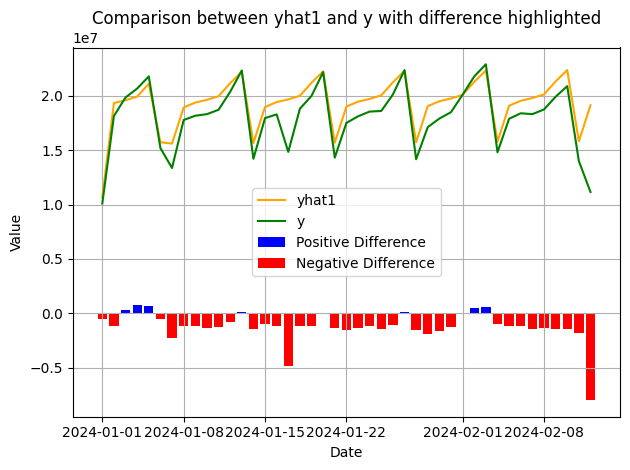

In [19]:
generate_comparison_plot(forecast, test_data)

In [36]:
model_params

{'growth': 'linear',
 'seasonality_mode': 'multiplicative',
 'learning_rate': 0.003,
 'n_changepoints': 1,
 'changepoints_range': 0.95,
 'yearly_seasonality': False,
 'weekly_seasonality': True,
 'daily_seasonality': False,
 'epochs': 150,
 'trend_reg': 10}

Training: 0it [00:00, ?it/s]

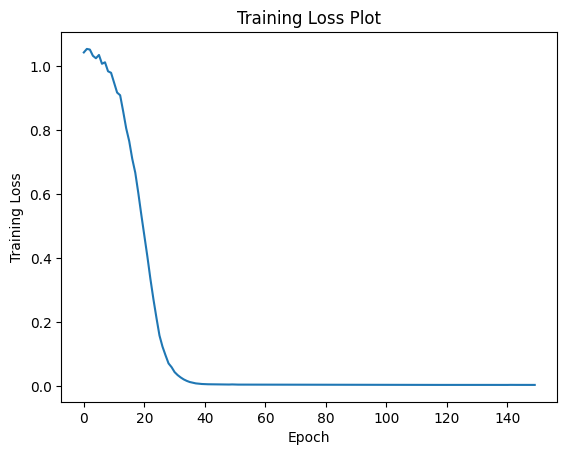

Predicting: 35it [00:00, ?it/s]

{'Mean Absolute Error': 887332.4418604651, 'Mean Squared Error': 2123566255066.3953, 'Root Mean Squared Error': 1457246.1202783815, 'Mean Absolute Percentage Error': 5.576900404361538, 'Symmetric Mean Absolute Percentage Error': 5.079250870305884, 'R-squared': 0.7536504298999768}


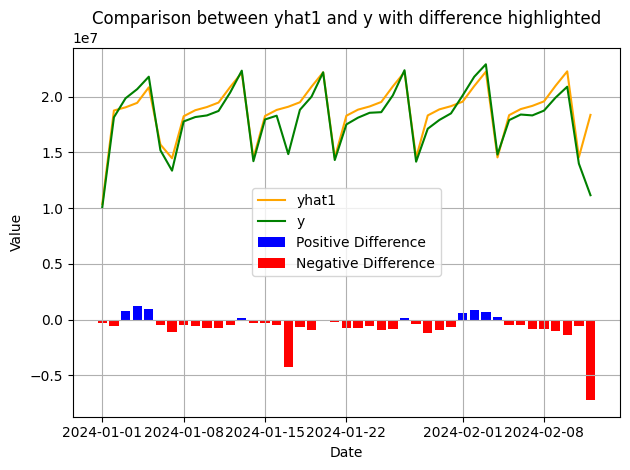

In [3]:
import logging
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
from neuralprophet.utils import set_log_level

hyperparameters = {
    'growth': 'linear',
    'seasonality_mode': 'multiplicative',
    'learning_rate': 0.003,
    'n_changepoints': 1,
    'changepoints_range': 0.95,
    'yearly_seasonality':  False,
    'weekly_seasonality': True,
    'daily_seasonality': "auto",
    'epochs': 150,
    'trend_reg': 5
}

try:
    logging.info("Model building")
    # Disable logging messages unless there is an error
    set_log_level("ERROR")

    # Create a NeuralProphet model with default parameters
    m = NeuralProphet(**hyperparameters)
    m.add_country_holidays("IT")
    np.random.seed(42)
    # Fit the model on the dataset
    metrics = m.fit(train_data, freq="D")

    # Collect the training loss values
    train_loss_values = metrics["Loss"]

    # Plot the training loss values
    plt.plot(range(len(train_loss_values)), train_loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Plot')
    plt.show()

    # Optionally, you can also continue with the rest of your code...

    # Make future dataframe
    future = m.make_future_dataframe(train_data, periods=len(test_data))
    # Forecast
    forecast = m.predict(future)
    # Compute forecast metrics
    cust_metrics = compute_forecast_metrics(forecast, test_data)
    print(cust_metrics)
    # Generate comparison plot
    plt = generate_comparison_plot(forecast, test_data)

except Exception as e:
    custom_exception = CustomException(e, sys)
    logging.error(custom_exception)


In [4]:
m.config

{'growth': 'linear',
 'changepoints': None,
 'n_changepoints': 1,
 'changepoints_range': 0.95,
 'trend_reg': 5,
 'trend_reg_threshold': False,
 'trend_global_local': 'global',
 'yearly_seasonality': False,
 'weekly_seasonality': True,
 'daily_seasonality': 'auto',
 'seasonality_mode': 'multiplicative',
 'seasonality_reg': 0,
 'season_global_local': 'global',
 'n_forecasts': 1,
 'n_lags': 0,
 'ar_layers': [],
 'ar_reg': None,
 'lagged_reg_layers': [],
 'learning_rate': 0.003,
 'epochs': 150,
 'batch_size': None,
 'loss_func': 'Huber',
 'optimizer': 'AdamW',
 'newer_samples_weight': 2,
 'newer_samples_start': 0.0,
 'quantiles': [],
 'impute_missing': True,
 'impute_linear': 10,
 'impute_rolling': 10,
 'drop_missing': False,
 'collect_metrics': True,
 'normalize': 'auto',
 'global_normalization': False,
 'global_time_normalization': True,
 'unknown_data_normalization': False,
 'accelerator': None,
 'trainer_config': {},
 'prediction_frequency': None}

In [6]:
import pickle
with open('models/neuralprophet_model_789.pkl', "wb") as f:
    pickle.dump(m, f)

In [ ]:
# import matplotlib.pyplot as plt

# # Extracting data
# x = joined_df["ds"]
# y1 = joined_df["yhat1"]
# y2 = joined_df["NMSG"]
# difference = joined_df["difference"]

# # Plotting
# plt.figure(figsize=(10, 6))

# # Plotting yhat1 and NMSG
# plt.plot(x, y1, label='yhat1')
# plt.plot(x, y2, label='NMSG')

# # Highlighting the difference
# for i in range(len(x)):
#     plt.annotate(f'{difference[i]:.0f}', (x[i], y1[i]), textcoords="offset points", xytext=(0,10), ha='center')

# # Adding labels, title, and legend
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Comparison between yhat1 and NMSG with difference highlighted')
# plt.legend()

# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# plt.tight_layout()
# plt.grid(True)  # Adding grid
# plt.show()


In [ ]:
# ####################################################################################################
# # 1. Checking missing columns
# # 2. Unique SERVERS
# ####################################################################################################
# table_lst = df.columns.to_list()
# doc_lst=["DT","SERVER","NMSG","NMSGNP","N1100","N1120","N1420","TPSRT","TPSNRT","TDRRT","TDRNRT","TDRMAXRT","TDRMAXNRT","TO200RT","TO200NRT","TO500RT","TO500NRT","N1200","NADVTO","N1220","NADVOF","NPOKER","TDRPOKER","TDRMAXPOKER","NAICLOUD","N_NS_AICLOUD","N_RESP_AICLOUD","N_TO_AICLOUD","TDR_AICLOUD","TDRMAX_AICLOUD","TO200RT_AICLOUD","TO200NRT_AICLOUD","TO500RT_AICLOUD","TO500NRT_AICLOUD"]
# missing_cols =[]
# for col in doc_lst:
#     if col not in table_lst:
#         missing_cols.append(col)
# print("Missing columns:", missing_cols)

# print("SERVER names:", df["SERVER"].unique())